<a href="https://colab.research.google.com/github/arpanbiswas52/SANE/blob/main/SANE_synthetic2D(Notebook_Github).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Strategic (S) Autonomous (A) Noisy (N) Experiments (E)**
Aug, 2024

Tutorial for Stategic BO where the idea is to also exploit the local optimal solution rather than only focus of BO to identify the global optimal solution

In real time, experts also want to learn the material structure-property relationship at the local region of interest and want to spend some time exploring those spaces. However, the classical BO is a global optimization tool where it only focus on exploiting to converge to optimal region globally and avoid local optima. Here, we aim to define BO with strategic exploration to indentify a potential optimal region and exploit sufficiently to extract physical knowledge and the move to identify the next optimal region. This approach is well suited when we have mutiple local and global region of interest and the domain expert want to learn all the region, but with limited experiments.

-- Notebook prepared by **Arpan Biswas**





In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax.git
!pip install mycolorpy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3850 sha256=83c5838f33d5e7b7b3c6739118c3c84f663a13d76245bad54f61664d3fe7803d
  Stored in directory: /root/.cache/pip/wheels/d6/1d/04/f8bfb8b04e3daba330b3f377c041b89304271ff98fb6704946
Successfully built mycolorpy


In [ ]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

from typing import Union, Dict, Callable

import math

import jax.numpy as jnp
from jax import jit
from gpax.kernels import RBFKernel

import jax
import numpyro
from mycolorpy import colorlist as mcp

In [ ]:

def cost_acqfun(models, train_x, Data, cost_params, params, ieval, isnorm=False):
    """
    cost based acquisition function- EI based
    Args:
        model: krigging model
        train_x: training data
        Data: Unexplored data to evaluate for next sample selection in list with actual values and normalized values
        cost_params: Params required for cost aware acquisition function
        params: Params required for standard EI acq function
        ieval: All the current locations explored
        isnorm: If the data need to be normalized. Default is False

    Returns:
        array of acquisition function values, maximum acquistion value location and value
    """

    data_real = Data[0] # True data
    data_norm = Data[1] #Normalize data

    best_x = cost_params[0]
    exp_x = cost_params[1]
    a = cost_params[2]
    b = cost_params[3]
    switch = cost_params[4]

    if isnorm == False:
        data = data_real
        # print(data)
    else:
        data = data_norm
        # print(data)

    gp_model = models
    # Compute standard acq function
    standard_acq = gpax.acquisition.qEI(params, gp_model, data, maximize=True, noiseless=True)
    standard_acq = np.array(standard_acq[0,:])

    # Check for stability
    standard_acq[np.isnan(standard_acq)==True] = np.random.uniform(low=0.0, high=1.0, size=standard_acq[np.isnan(standard_acq)==True].shape)*1e-3
    # Eliminate evaluated samples from consideration to avoid repeatation in future sampling
    #standard_acq[ieval] = 0

    # Compute cost on non-normalized data
    prev_x = train_x[-1,:]
    x_center = best_x
    l_exp = len(exp_x)-1
    cost = np.zeros((standard_acq.shape[0], 2))
    c = np.zeros((standard_acq.shape[0]))

    for i in range(data_real.shape[0]):
        cost[i, 0] = a*(np.absolute(data_real[i,0]-x_center[0])+np.absolute(data_real[i,1]-x_center[1])) # encourage local exploration

        for j in range(l_exp): # discourage already invested locations of potential region of interest
          cost[i, 1] = cost[i, 1] + b*(np.absolute(data_real[i,0]-train_x[exp_x[j], 0])+np.absolute(data_real[i,1]-train_x[exp_x[j], 1]))
        if l_exp > 0:
          cost[i, 1] = cost[i, 1]/l_exp
          #cost[:, 1] = 0
        c[i] = -cost[i, 0] + cost[i, 1]
        #if c[i] < 0:
        #  c[i] = 0.1

    c = (c-np.min(c))/(np.max(c)-np.min(c))

    if (np.max(standard_acq)+1e-5)/(np.sum(standard_acq)+1e-5) >= 0.99:
        print("Full local exploration initiated")
        #standard_acq = 0*standard_acq
        cost_acq = c

    else:
        if switch == 1: #Explorative
          cost_acq = standard_acq*(np.sum(cost, axis=1))
        else: #Exploitative
          cost_acq = standard_acq/np.sum(cost, axis=1)


    cost_acq[ieval] = 0
    #print(cost_acq)
    # Find maximum acquisition value and location
    maxacq_idx = cost_acq.argmax()
    maxacq_val = cost_acq.max()
    nextpt = data_real[maxacq_idx]
    cost_nextpt = cost[maxacq_idx, :]


    # Optional- Print acq functions
    plt.scatter(data_real[:, 0], data_real[:, 1], c=standard_acq, cmap="viridis")
    plt.colorbar(orientation='vertical')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Standard acquistion map")
    plt.show()

    plt.scatter(data_real[:, 0], data_real[:, 1], c=cost_acq, cmap="viridis")
    plt.colorbar(orientation='vertical')
    plt.scatter(nextpt[0], nextpt[1], label="next", marker = 'X', c="g")
    plt.scatter(prev_x[0], prev_x[1], label="previous", marker = 'X', c="k")
    plt.legend(loc="best")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Cost aware acquistion map")
    plt.show()

    return cost_acq, maxacq_idx, maxacq_val, cost_nextpt

def check_ROI(train_x, train_y, best_x, best_y, exp_x):
    #best_y2 = np.max(train_y[exp_x[-1]+1:])
    #best_x2 = train_x[np.argmax(train_y[exp_x[-1]+1:])]
    #Find Euclidean distance between best x and the later explored x
    l = len(train_x[exp_x[-1]+1:])
    l_exp = len(exp_x)-1
    dist_x = np.zeros(l)
    dist_y = np.zeros(l)
    dist_z = np.zeros(l)
    for i in range(l):
        dist_x[i] = np.absolute(best_x[0] - train_x[exp_x[-1]+i+1,0]) + np.absolute(best_x[1] - train_x[exp_x[-1]+i+1,1])
        dist_y[i] = train_y[exp_x[-1]+i+1]/best_y
        for j in range(l_exp): # discourage already invested locations of potential region of interest
          dist_z[i] = dist_z[i] + np.absolute(train_x[exp_x[-1]+i+1,0] - train_x[exp_x[j],0]) + np.absolute(train_x[exp_x[-1]+i+1,1] - train_x[exp_x[j],1])
        dist_z[i] = dist_z[i]/l_exp

    dim_x = len(best_x)

    F = (dist_x * dist_y * dist_z)/dim_x
    F_max = np.max(F)
    F_imax= np.argmax(F)


    prob_ROI = (dist_x[F_imax]/dim_x + dist_y[F_imax]/dim_x)
    if prob_ROI > 1:
        prob_ROI = 1
    #print(F_max, prob_ROI)
    #D = np.max(dist_x/dim_x) #Measure closeness

    #O = np.max(dist_y) #Measure optimality
    # We want to maximize D and O
    #print(D, O)
    #prob_ROI = min(D, O)
    #print(prob_ROI)
    #Probabilistic choice of identify the next best solution as a potential ROI
    if np.random.choice(np.arange(2), size=1, p =[1-prob_ROI, prob_ROI]) == 1: #New ROI
        exp_x = np.hstack((exp_x, int(exp_x[-1]+F_imax+1)))
        print(exp_x)
        print("New potential region of interest found with prob=", prob_ROI)
    else:
        exp_x = exp_x #No new ROI

    return exp_x

In [ ]:
#define objective
def objective(x):
    # https://www.sfu.ca/~ssurjano/branin.html
    x1 = x[:, 0]
    x2 = x[:, 1]
    a = 1
    b = 5.1/(4*np.pi**2),
    c = 5/np.pi
    r = 6
    s = 10
    t = 1/(8*np.pi)
    y = a*(x2 - b*x1**2 + c*x1 - r)**2 + s*(1-t)*jnp.cos(x1) + s
    return y

lb = -5
ub = 15
N_total =40
xs1 = np.linspace(lb, ub, N_total)
xs2 = np.linspace(lb, ub, N_total)
xs = np.zeros((N_total*N_total,2))
k = 0
for i in range(len(xs1)):
  for j in range(len(xs2)):
    xs[k, 0] = xs1[i]
    xs[k, 1] = xs2[j]
    k = k+1
xs_norm = (xs-lb)/(ub-lb)
bounds = np.array((lb, ub), dtype=float)

ys = objective(xs)/100
ys_norm = (ys-np.min(ys))/(np.max(ys)-np.min(ys))


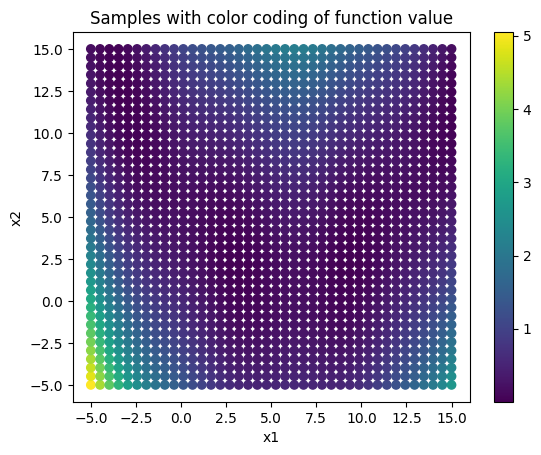

In [ ]:

plt.scatter(xs[:, 0], xs[:, 1], c=ys, cmap="viridis")
plt.colorbar(orientation='vertical')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Samples with color coding of function value")
plt.show()


# Human-strategic Bayesian Optimization

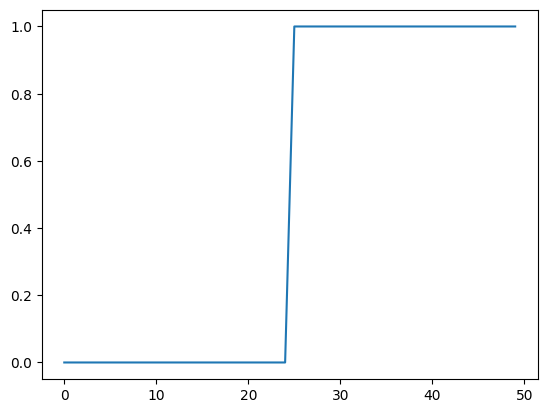

In [ ]:
k = np.zeros(50)
k[25:] = k[25:] + 1
plt.plot(k)

# Run 1

Initial Sampling- 10 samples

In [ ]:
n = 10

np.random.seed(1000)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 2)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])

train_x, train_x_norm

(array([[ 8.07179171, -2.69986114],
        [14.00565729,  4.64382803],
        [12.4494907 , -0.75334638],
        [-4.1858075 ,  2.94388923],
        [-0.33735605, 11.83481449],
        [-0.85835311,  9.84939067],
        [ 2.84308256, -1.3548696 ],
        [ 9.87078829, -3.60835838],
        [12.70674409, 14.05288798],
        [13.62286869,  3.30861906]]),
 array([[0.65358959, 0.11500694],
        [0.95028286, 0.4821914 ],
        [0.87247454, 0.21233268],
        [0.04070962, 0.39719446],
        [0.2331322 , 0.84174072],
        [0.20708234, 0.74246953],
        [0.39215413, 0.18225652],
        [0.74353941, 0.06958208],
        [0.8853372 , 0.9526444 ],
        [0.93114343, 0.41543095]]))

In [ ]:
train_y = objective(train_x)
train_y=train_y/100
train_y

Array([0.26158559, 0.30672916, 0.68001174, 1.48729788, 0.46973002,
       0.21979775, 0.1583178 , 0.43396011, 0.74534309, 0.39566784],      dtype=float64)

In [ ]:
best_x = train_x[np.argmax(train_y)]
best_x_norm = train_x_norm[np.argmax(train_y)]
best_x, best_x_norm

(array([-4.1858075 ,  2.94388923]), array([0.04070962, 0.39719446]))

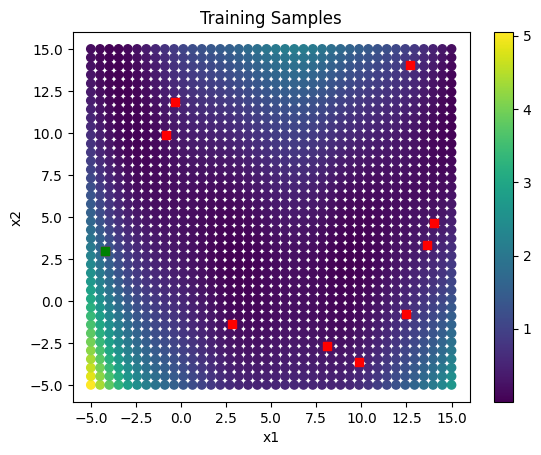

In [ ]:
plt.scatter(xs[:, 0], xs[:, 1], c=ys, cmap="viridis")
plt.colorbar(orientation='vertical')
plt.scatter(train_x[:, 0], train_x[:, 1], c="r", alpha =1, marker="s")
plt.scatter(best_x[0], best_x[1], c="g", alpha =1, marker="s")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Training Samples")
plt.show()



Run BO- 50 iterations

In [ ]:
c_loc = 1
c_glo = 1

In [ ]:
N = 50
n = 5 # Check for best results
m = 0
X_test =xs
X_test_full = xs
X_test_norm = xs_norm

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
exp_x = [int(np.argmax(train_y))]
cost = np.zeros((N, 2))
for i in range(1, N+1):
    print("Step:"+str(i))
    # Checking criteria wheather we find a potential region of interest to exploit-- can be a local or global optima
    if m == n:
        best_x = train_x[exp_x[-1]]
        best_x_norm = train_x_norm[exp_x[-1]]
        m = 0

        if np.isin(exp_x, int(np.argmax(train_y))).any()== True: #New potential region of interest found with low function values

            train_y_norm = (train_y-np.min(train_y))/(np.max(train_y)-np.min(train_y))
            best_y_norm = np.max(train_y_norm)
            # Need to provide normalized value of X and Y
            print("Checking for ROI with potntial local optima")
            exp_x = check_ROI(train_x_norm, train_y_norm, best_x_norm, best_y_norm, exp_x)
            best_x = train_x[exp_x[-1]]
            best_x_norm = train_x_norm[exp_x[-1]]
        else:
            exp_x = np.hstack((exp_x, int(np.argmax(train_y)))) #New potential ROI found with higher function values
            best_x = train_x[exp_x[-1]]
            best_x_norm = train_x_norm[exp_x[-1]]
            print("New ROI with potential global optima found")

    m = m + 1

    # Initialize MF model
    gp_model = gpax.ExactGP(1, kernel='RBF')
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x_norm, train_y, num_warmup=500, num_samples=500, num_chains=1)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict_in_batches(rng_key_predict, X_test_norm)

        fig, ax = plt.subplots(ncols = 3, figsize=(18, 5))
        a=ax[0].scatter(X_test[:, 0], X_test[:, 1], c=ys, cmap="viridis")
        ax[0].scatter(train_x[:, 0], train_x[:, 1], c="r", alpha =1, marker="s")
        ax[0].scatter(train_x[exp_x[-1], 0], train_x[exp_x[-1], 1], c="g", alpha =1, marker="s")
        plt.colorbar(a, orientation='vertical')
        ax[0].set_xlabel("x1")
        ax[0].set_ylabel("x2")
        ax[0].set_title("Ground truth")

        b= ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap="viridis")
        plt.colorbar(b, orientation='vertical')
        ax[1].set_xlabel("x1")
        ax[1].set_ylabel("x2")
        ax[1].set_title("GPmean")

        b= ax[2].scatter(X_test[:, 0], X_test[:, 1], c=y_sampled.std(axis=(0,1)), cmap="viridis")
        plt.colorbar(b, orientation='vertical')
        ax[2].set_xlabel("x1")
        ax[2].set_ylabel("x2")
        ax[2].set_title("GPvar")
        plt.show()
    # Compute the MF acq function - EI based
    test_data = [X_test, X_test_norm]
    cost_params = [best_x, exp_x, c_loc, c_glo, int(k[i-1])]
    acq, next_point_idx, next_point_val,  cost[i-1, :] = cost_acqfun(gp_model, train_x, test_data, cost_params, rng_key_predict, idx, isnorm=True)
    print("local cost:"+str(cost[i-1, 0]))
    print("global cost:"+str(cost[i-1, 1]))

    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        next_point_norm = X_test_norm[next_point_idx]
        train_x_norm = np.vstack((train_x_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)
        train_y = objective(train_x[:, 0:2])
        train_y=train_y/100



Standard BO

In [ ]:
N = 50
n = 5 # Check for best results
X_test =xs
X_test_full = xs
X_test_norm = xs_norm

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
exp_x = [int(np.argmax(train_y))]
cost = np.zeros((N, 2))
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize MF model
    gp_model = gpax.ExactGP(1, kernel='RBF')
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x_norm, train_y, num_warmup=500, num_samples=500, num_chains=1)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict_in_batches(rng_key_predict, X_test_norm)

        fig, ax = plt.subplots(ncols = 3, figsize=(18, 5))
        a=ax[0].scatter(X_test[:, 0], X_test[:, 1], c=ys, cmap="viridis")
        ax[0].scatter(train_x[:, 0], train_x[:, 1], c="r", alpha =1, marker="s")
        ax[0].scatter(train_x[exp_x[-1], 0], train_x[exp_x[-1], 1], c="g", alpha =1, marker="s")
        plt.colorbar(a, orientation='vertical')
        ax[0].set_xlabel("x1")
        ax[0].set_ylabel("x2")
        ax[0].set_title("Ground truth")

        b= ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap="viridis")
        plt.colorbar(b, orientation='vertical')
        ax[1].set_xlabel("x1")
        ax[1].set_ylabel("x2")
        ax[1].set_title("GPmean")

        b= ax[2].scatter(X_test[:, 0], X_test[:, 1], c=y_sampled.std(axis=(0,1)), cmap="viridis")
        plt.colorbar(b, orientation='vertical')
        ax[2].set_xlabel("x1")
        ax[2].set_ylabel("x2")
        ax[2].set_title("GPvar")
        plt.show()

    # Compute standard acq function
    standard_acq = gpax.acquisition.qEI(rng_key_predict, gp_model, X_test_norm, maximize=True, noiseless=True)
    standard_acq = np.array(standard_acq[0,:])
    standard_acq[idx] = 0
    # Find maximum acquisition value and location
    next_point_idx = standard_acq.argmax()
    next_point_val = standard_acq.max()

    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        next_point_norm = X_test_norm[next_point_idx]
        train_x_norm = np.vstack((train_x_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)
        train_y = objective(train_x[:, 0:2])
        train_y=train_y/100



# Run 2

In [ ]:
n = 10

np.random.seed(10000)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 2)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])

train_x, train_x_norm

(array([[ 5.90940302, -1.5626937 ],
        [12.05863619, -1.39553178],
        [ 6.774001  , -2.58450199],
        [ 6.09397501, -3.35947644],
        [14.85410349,  0.05438523],
        [ 5.65920027, 12.84278195],
        [-0.15812749,  3.35241478],
        [12.35890968,  0.72660482],
        [-2.24600673, -3.98412795],
        [13.56581743, 10.59900284]]),
 array([[0.54547015, 0.17186532],
        [0.85293181, 0.18022341],
        [0.58870005, 0.1207749 ],
        [0.55469875, 0.08202618],
        [0.99270517, 0.25271926],
        [0.53296001, 0.8921391 ],
        [0.24209363, 0.41762074],
        [0.86794548, 0.28633024],
        [0.13769966, 0.0507936 ],
        [0.92829087, 0.77995014]]))

In [ ]:
train_y = objective(train_x)
train_y=train_y/100
train_y

Array([0.26061847, 0.67228901, 0.32390765, 0.39305209, 1.20512431,
       1.54971685, 0.27906724, 0.47864454, 2.05934577, 0.21027952],      dtype=float64)

In [ ]:
best_x = train_x[np.argmax(train_y)]
best_x_norm = train_x_norm[np.argmax(train_y)]
best_x, best_x_norm

(array([-2.24600673, -3.98412795]), array([0.13769966, 0.0507936 ]))

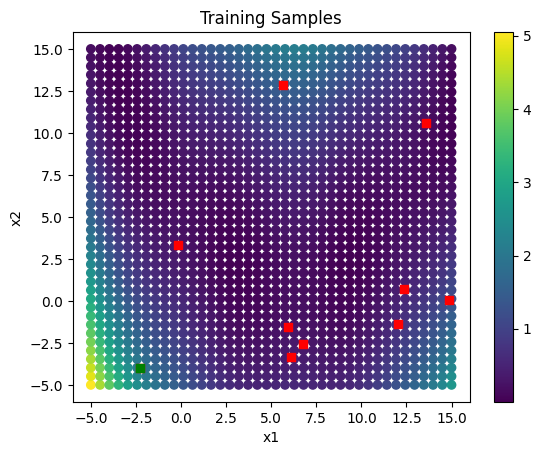

In [ ]:
plt.scatter(xs[:, 0], xs[:, 1], c=ys, cmap="viridis")
plt.colorbar(orientation='vertical')
plt.scatter(train_x[:, 0], train_x[:, 1], c="r", alpha =1, marker="s")
plt.scatter(best_x[0], best_x[1], c="g", alpha =1, marker="s")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Training Samples")
plt.show()



In [ ]:
c_loc = 1
c_glo = 1

In [ ]:
N = 50
n = 5 # Check for best results
m = 0
X_test =xs
X_test_full = xs
X_test_norm = xs_norm

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
exp_x = [int(np.argmax(train_y))]
cost = np.zeros((N, 2))
for i in range(1, N+1):
    print("Step:"+str(i))
    # Checking criteria wheather we find a potential region of interest to exploit-- can be a local or global optima
    if m == n:
        best_x = train_x[exp_x[-1]]
        best_x_norm = train_x_norm[exp_x[-1]]
        m = 0

        if np.isin(exp_x, int(np.argmax(train_y))).any()== True: #New potential region of interest found with low function values

            train_y_norm = (train_y-np.min(train_y))/(np.max(train_y)-np.min(train_y))
            best_y_norm = np.max(train_y_norm)
            # Need to provide normalized value of X and Y
            print("Checking for ROI with potntial local optima")
            exp_x = check_ROI(train_x_norm, train_y_norm, best_x_norm, best_y_norm, exp_x)
            best_x = train_x[exp_x[-1]]
            best_x_norm = train_x_norm[exp_x[-1]]
        else:
            exp_x = np.hstack((exp_x, int(np.argmax(train_y)))) #New potential ROI found with higher function values
            best_x = train_x[exp_x[-1]]
            best_x_norm = train_x_norm[exp_x[-1]]
            print("New ROI with potential global optima found")

    m = m + 1

    # Initialize MF model
    gp_model = gpax.ExactGP(1, kernel='RBF')
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x_norm, train_y, num_warmup=500, num_samples=500, num_chains=1)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict_in_batches(rng_key_predict, X_test_norm)

        fig, ax = plt.subplots(ncols = 3, figsize=(18, 5))
        a=ax[0].scatter(X_test[:, 0], X_test[:, 1], c=ys, cmap="viridis")
        ax[0].scatter(train_x[:, 0], train_x[:, 1], c="r", alpha =1, marker="s")
        ax[0].scatter(train_x[exp_x[-1], 0], train_x[exp_x[-1], 1], c="g", alpha =1, marker="s")
        plt.colorbar(a, orientation='vertical')
        ax[0].set_xlabel("x1")
        ax[0].set_ylabel("x2")
        ax[0].set_title("Ground truth")

        b= ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap="viridis")
        plt.colorbar(b, orientation='vertical')
        ax[1].set_xlabel("x1")
        ax[1].set_ylabel("x2")
        ax[1].set_title("GPmean")

        b= ax[2].scatter(X_test[:, 0], X_test[:, 1], c=y_sampled.std(axis=(0,1)), cmap="viridis")
        plt.colorbar(b, orientation='vertical')
        ax[2].set_xlabel("x1")
        ax[2].set_ylabel("x2")
        ax[2].set_title("GPvar")
        plt.show()
    # Compute the MF acq function - EI based
    test_data = [X_test, X_test_norm]
    cost_params = [best_x, exp_x, c_loc, c_glo, int(k[i-1])]
    acq, next_point_idx, next_point_val,  cost[i-1, :] = cost_acqfun(gp_model, train_x, test_data, cost_params, rng_key_predict, idx, isnorm=True)
    print("local cost:"+str(cost[i-1, 0]))
    print("global cost:"+str(cost[i-1, 1]))

    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        next_point_norm = X_test_norm[next_point_idx]
        train_x_norm = np.vstack((train_x_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)
        train_y = objective(train_x[:, 0:2])
        train_y=train_y/100



Standard BO

In [ ]:
N = 50
n = 5 # Check for best results
X_test =xs
X_test_full = xs
X_test_norm = xs_norm

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
exp_x = [int(np.argmax(train_y))]
cost = np.zeros((N, 2))
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize MF model
    gp_model = gpax.ExactGP(1, kernel='RBF')
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x_norm, train_y, num_warmup=500, num_samples=500, num_chains=1)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict_in_batches(rng_key_predict, X_test_norm)

        fig, ax = plt.subplots(ncols = 3, figsize=(18, 5))
        a=ax[0].scatter(X_test[:, 0], X_test[:, 1], c=ys, cmap="viridis")
        ax[0].scatter(train_x[:, 0], train_x[:, 1], c="r", alpha =1, marker="s")
        ax[0].scatter(train_x[exp_x[-1], 0], train_x[exp_x[-1], 1], c="g", alpha =1, marker="s")
        plt.colorbar(a, orientation='vertical')
        ax[0].set_xlabel("x1")
        ax[0].set_ylabel("x2")
        ax[0].set_title("Ground truth")

        b= ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap="viridis")
        plt.colorbar(b, orientation='vertical')
        ax[1].set_xlabel("x1")
        ax[1].set_ylabel("x2")
        ax[1].set_title("GPmean")

        b= ax[2].scatter(X_test[:, 0], X_test[:, 1], c=y_sampled.std(axis=(0,1)), cmap="viridis")
        plt.colorbar(b, orientation='vertical')
        ax[2].set_xlabel("x1")
        ax[2].set_ylabel("x2")
        ax[2].set_title("GPvar")
        plt.show()

    # Compute standard acq function
    standard_acq = gpax.acquisition.qEI(rng_key_predict, gp_model, X_test_norm, maximize=True, noiseless=True)
    standard_acq = np.array(standard_acq[0,:])
    standard_acq[idx] = 0
    # Find maximum acquisition value and location
    next_point_idx = standard_acq.argmax()
    next_point_val = standard_acq.max()

    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        next_point_norm = X_test_norm[next_point_idx]
        train_x_norm = np.vstack((train_x_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)
        train_y = objective(train_x[:, 0:2])
        train_y=train_y/100

